### Imports

In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import kstest

### A

In [2]:
m = 2**(35)
a1 = np.floor(np.pi * 10**9)
a0 = np.floor(np.e * 10**9)
n = 100000
x0 = 22
np.random.seed(2137)

In [3]:
# linear congruential generator 
# uniform [0,1]
def lcg(how_many_numbers, period=m, a=a1, c=a0, seed=x0):
    x = np.zeros(how_many_numbers)
    x[0] = seed
    for i in range(1, how_many_numbers):
        x[i] = (a * x[i-1] + c) % period
    return x / period

In [4]:
numbers = lcg(how_many_numbers=n)

<Axes: ylabel='Count'>

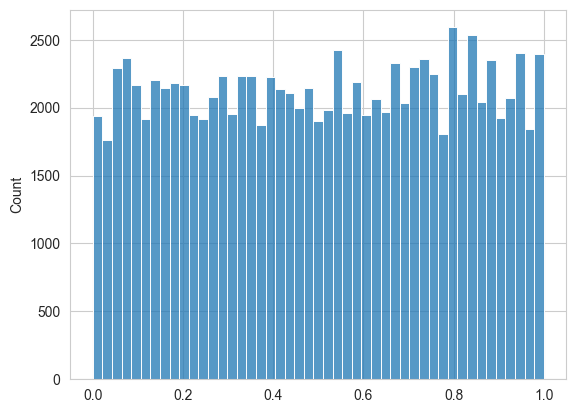

In [5]:
sns.histplot(numbers)

In [6]:
# unique values
len(np.unique(numbers))

10602

In [7]:
len(numbers)

100000

<Axes: ylabel='Count'>

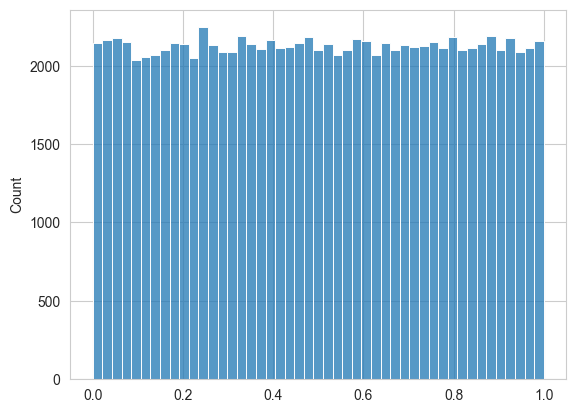

In [8]:
random_numbers = np.random.rand(n)
sns.histplot(random_numbers)

<Axes: ylabel='Proportion'>

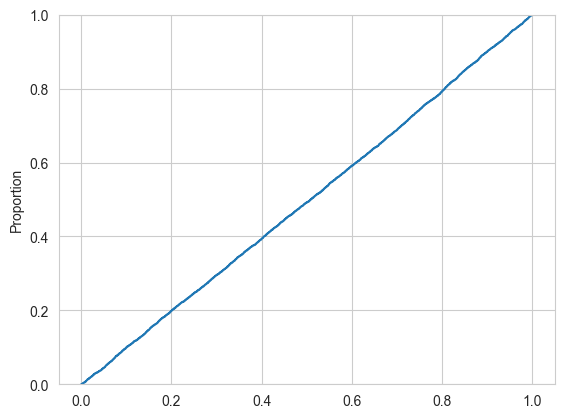

In [9]:
sns.ecdfplot(numbers)

<Axes: ylabel='Proportion'>

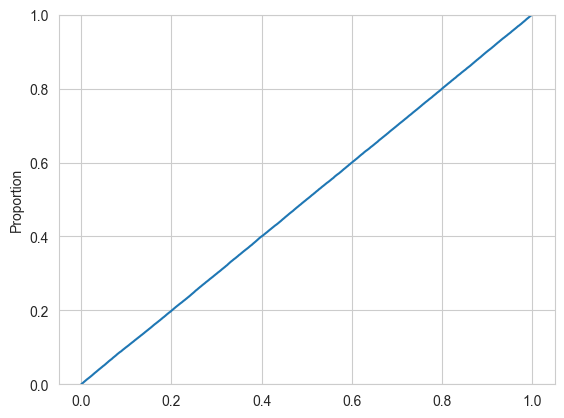

In [10]:
sns.ecdfplot(random_numbers)

In [11]:
kstest(numbers, 'uniform')

KstestResult(statistic=0.013592180328369174, pvalue=1.776310529673537e-16, statistic_location=0.6592621803283691, statistic_sign=-1)

In [12]:
kstest(random_numbers, 'uniform')

KstestResult(statistic=0.0017740042271594259, pvalue=0.9107876340091263, statistic_location=0.23819400422715942, statistic_sign=-1)

### B
$$
f(x) = \frac{\left(1 + \cos(2\pi x)\right) e^{-x^2 / 2}}{\left(1 + e^{-2\pi^2}\right) \sqrt{2\pi}}.
$$


In [13]:
def fb(x):
    return (1 + np.cos(2 * np.pi * x)) * np.exp(-x**2 / 2) / ((1 + np.exp(-2 * np.pi**2)) * np.sqrt(2 * np.pi))

# Box-Muller method for generating normal distribution N(0,1) from uniform distribution U(0,1)
def normal_box_muller(how_many_numbers, mu=0, variance=1, seed_one=22, seed_two=2137):
    u1 = lcg(how_many_numbers, seed = seed_one)
    u2 = lcg(how_many_numbers, seed = seed_two) # different seed because of independence
    z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    #z2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    all_numbers = z1
    return mu + np.sqrt(variance) * all_numbers

### Box-Muller Method

The Box-Muller method is a technique for generating random variables from the standard normal distribution \( $\mathcal{N}(0,1)$ \) using only uniformly distributed random variables \( $U(0,1)$ \).  

#### Algorithm:
1. Generate two independent random variables \($ U_1, U_2 \sim U(0,1) $\).
2. Compute:
   $$
   Z_1 = \sqrt{-2 \ln U_1} \cos(2\pi U_2),
   $$
   $$
   Z_2 = \sqrt{-2 \ln U_1} \sin(2\pi U_2).
   $$
3. The obtained values \( $Z_1$, $Z_2$ \) are independent samples from the standard normal distribution \( $\mathcal{N}(0,1)$ \).

This method is based on a transformation of uniform random variables and utilizes the fact that a pair of uniform variables can be mapped to normally distributed variables using a polar coordinate transformation.  
The method is named after George E. P. Box and Mervin E. Muller, who first described it in 1958.

<Axes: ylabel='Count'>

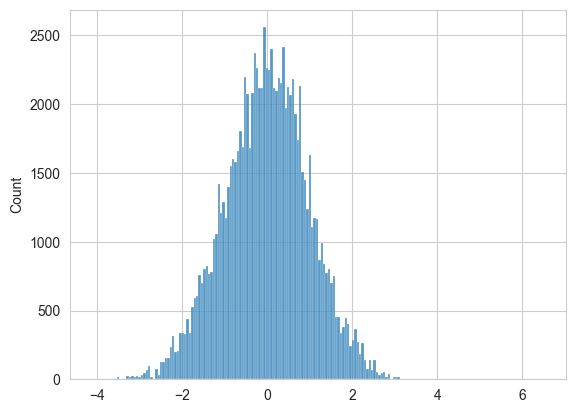

In [14]:
#test for normal distribution and histogram
n = 100000
numbers = normal_box_muller(n)
sns.histplot(numbers)

### YEY! It works!
we have normal distribution

In [15]:
kstest(numbers, 'norm')

KstestResult(statistic=0.011843439363606878, pvalue=1.2995901841863288e-12, statistic_location=0.8142759594148449, statistic_sign=1)

In [16]:
def g_normal(x): # normal distribution N(0,1) density function
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

We need to find the constant $a$ such that the condition:

$$
    f(x) \leq a g(x)
$$

holds for all values of $x$, where:

- $g(x)$ is the probability density function of the standard normal distribution $N(0,1)$:

  $$
      g(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}}
  $$

- $f(x)$ is given by:

  $$
      f(x) = \frac{(1 + \cos(2\pi x)) e^{-x^2 / 2}}{(1 + e^{-2\pi^2}) \sqrt{2\pi}}
  $$

Dividing $f(x)$ by $g(x)$:

$$
    \frac{f(x)}{g(x)} = \frac{(1 + \cos(2\pi x)) e^{-x^2 / 2}}{(1 + e^{-2\pi^2}) \sqrt{2\pi}} \cdot \frac{\sqrt{2\pi}}{e^{-x^2/2}}
$$

After simplification:

$$
    \frac{f(x)}{g(x)} = \frac{1 + \cos(2\pi x)}{1 + e^{-2\pi^2}}
$$

The constant $a$ should be greater than or equal to the maximum value of this expression. Since $\cos(2\pi x)$ takes values in the range $[-1,1]$, the maximum value is:

$$
    \max (1 + \cos(2\pi x)) = 2
$$

Thus, the optimal value of $a$ is:

$$
    a = \frac{2}{1 + e^{-2\pi^2}}
$$


In [17]:
a=2/(1+np.exp(-2*np.pi**2))
a

1.999999994649424

Generated numbers:  48632


<Axes: ylabel='Count'>

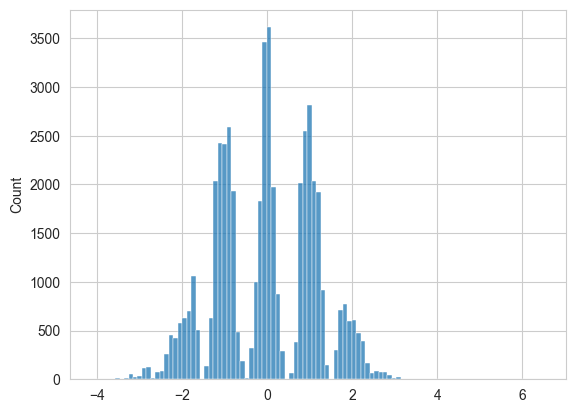

In [18]:
def modified_rejection_sampling(how_many_numbers, f, a_constant):
    u1 = lcg(how_many_numbers)
    n01 = normal_box_muller(how_many_numbers)
    numbers = []
    for i in range(how_many_numbers):
        if u1[i] <= f(n01[i]) / (a_constant * g_normal(n01[i])):
            numbers.append(n01[i])
    return np.array(numbers)

numbers = modified_rejection_sampling(100_000, fb, a)
print("Generated numbers: ", len(numbers))
sns.histplot(numbers)

<Axes: >

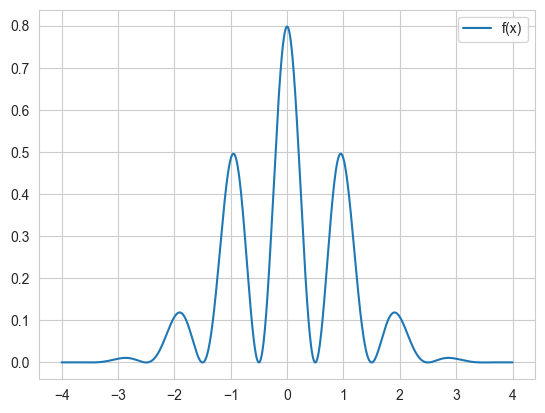

In [19]:
#compare with fb
x = np.linspace(-4, 4, 100_000)
y = fb(x)
sns.lineplot(x=x, y=y, label='f(x)')

# C
Poisson Process

## Poisson Process Method

To generate a sequence of Poisson-distributed random variables without using built-in functions, we can utilize the **interarrival time property** of a Poisson process. The method is based on the fact that the time intervals between consecutive events in a Poisson process follow an **exponential distribution** with rate $\lambda$.

### Algorithm
1. Initialize $S = 0$ and $k = 0$.
2. Generate a random variable $U \sim U(0,1)$ and compute the interarrival time:
   $$ T = -\frac{\ln U}{\lambda} $$
3. Accumulate the time: 
   $$ S = S + T $$
4. Repeat steps 2 and 3 until $S > 1$.
5. The count $k$ of arrivals before time 1 follows a **Poisson distribution** with parameter $\lambda$.
6. Return $k$ as the generated Poisson-distributed value.

### Mathematical Justification
Since the Poisson process models the number of events occurring in a fixed time interval, the number of arrivals in an interval of length 1 follows a Poisson distribution with mean $\lambda$. The waiting times between arrivals are exponentially distributed with probability density function:

$$
    f_T(t) = \lambda e^{-\lambda t}, \quad t > 0.
$$

Using the inverse transform sampling method, we obtain:

$$
    T = -\frac{\ln U}{\lambda},
$$

which allows us to iteratively simulate arrivals within the interval.

<Axes: ylabel='Count'>

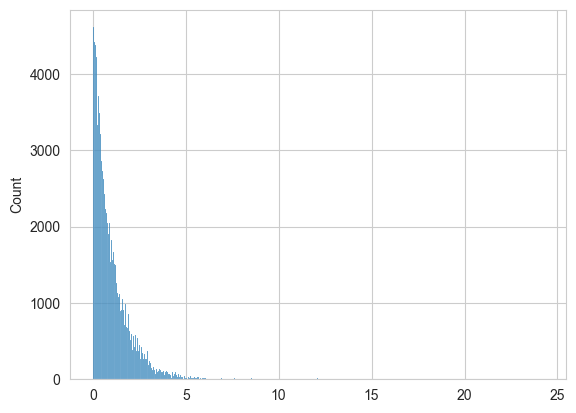

In [20]:
def exponential_generator(lam, n, seed=2137):
    return -np.log(lcg(n, seed=seed)) / lam

expo=exponential_generator(1, 100000,seed=1)
sns.histplot(expo)

In [21]:
expo

array([24.26015132,  1.7687573 ,  4.68594676, ...,  0.41216141,
        0.84605687,  0.29999994])

### Different approach
if $\lambda=1$ then $N_t \sim Poisson(t)$
we will just check how many events will happen for $t=1$, in fact we will add exponential random variables until we reach 1

<Axes: ylabel='Count'>

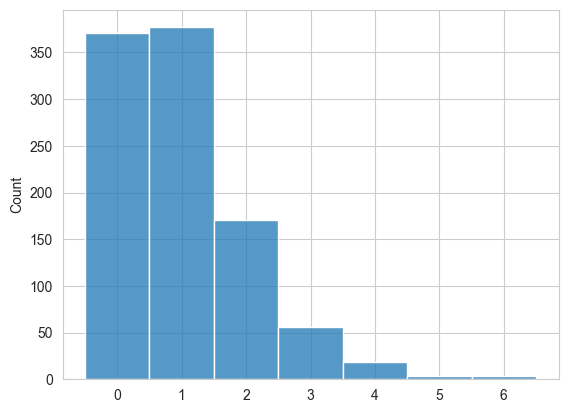

In [22]:
def generate_poisson(lam, seed=2137):
    t = 0
    k = 0
    i=0
    len_numbers = 10_000
    exp_numbers = exponential_generator(lam, len_numbers+1, seed)
    #remove first element, because it is mostly nearly 0
    exp_numbers = exp_numbers[1:]
    while t <= 1:
        t += exp_numbers[i]
        k += 1
        i+=1
        if i==len_numbers:
            seed += 1
            exp_numbers = exponential_generator(lam, len_numbers+1, seed)
            exp_numbers = exp_numbers[1:]
            i=0
    return k - 1
def poisson_generator(lam, n, seed=1):
    seeds = [seed + i for i in range(n)]
    return np.array([generate_poisson(lam, seed=seeds[i]) for i in range(n)])

numbers = poisson_generator(1, 1000, seed=21)
sns.histplot(numbers, discrete=True)

looks like Poisson distribution

In [23]:
kstest(numbers, 'poisson', args=(1,))

KstestResult(statistic=0.36787944117144245, pvalue=7.078187899043445e-122, statistic_location=0, statistic_sign=-1)

### C'
The distribution $p_k$ for $k \in \mathbb{Z} \setminus \{0\}$ is given by the formula:

$$
p_k = \frac{3}{\pi^2 k^2} \quad \text{for} \quad k \in \mathbb{Z} \setminus \{0\}, \quad p_0 = 0
$$

The sum of the distribution for all $k \in \mathbb{Z}$:

$$
\sum_{k=-\infty}^{\infty} p_k = 1
$$

The cumulative distribution function $F(k)$, where $F(k) = P(X_i \leq k)$, is the sum:

$$
F(k) = \sum_{i=-\infty}^{k} p_i
$$

In the inverse transform method, we generate a random variable $U \sim U(0, 1)$, then compute $k$ such that:

$$
F(k-1) \leq U < F(k)
$$

And assign:

$$
X_i = k
$$



### My observations/approach
if $U\leq \frac{1}{2}$ we can start from $ \sum^{-1}_{i=-\infty} p_i $ and try to subtract $p_i$ until we reach interval for $U$
similar for $U> \frac{1}{2}$ but we add etc

<Axes: ylabel='Count'>

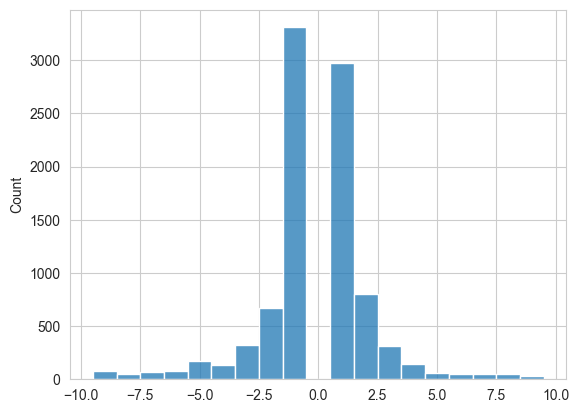

In [24]:
def pk(k):
    return 3/(np.pi**2 * k**2)

def generate_from_pk(n, seed=2137):
    u = lcg(n+1, seed=seed)
    u = u[1:]
    numbers = [0 for _ in range(n)]
    for i in range(n):
        q_i = 0.5
        if u[i] <= q_i:
            k = -1
            while True:
                q_i -= pk(k)
                if u[i] > q_i:
                    numbers[i] = k
                    break
                k -= 1
        else:
            k = 1
            while True:
                q_i += pk(k)
                if u[i] <= q_i:
                    numbers[i] = k
                    break
                k += 1   
    return np.array(numbers)

numbers = generate_from_pk(10000,seed=2221213722)
# create hist plot without extreme values
numbers2 = numbers[abs(numbers) < 10]
sns.histplot(numbers2, discrete=True)

In [25]:
np.unique(numbers)

array([-200, -167, -141, -112,  -70,  -59,  -53,  -43,  -36,  -34,  -26,
        -25,  -23,  -22,  -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,
        -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,
         -1,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   16,   19,   20,   22,   23,   27,   30,
         32,   33,   34,   37,   41,   50,   54,   55,   56,   59,   60,
         67,  119,  145,  161,  162,  191,  305,  336,  999])

<Axes: >

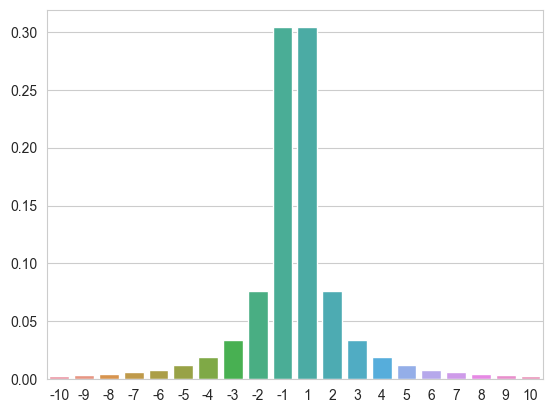

In [26]:
#without 0 
x = np.arange(-10, 11)
x = x[x != 0]
y = [pk(i) for i in x]
sns.barplot(x=x, y=y)

# D
$$
F(x) = \frac{1}{3} F_{B(10, 1/3)}(x) + \frac{1}{3} \Phi(x) + \frac{1}{3} F_{\text{EXP}(1)}(x)
$$

## let's start with binomial generator
To generate a random variable $X \sim B(n, p)$, we use the property that a binomially distributed variable can be expressed as the sum of independent Bernoulli trials:

$$
X = \sum_{i=1}^{n} I_i, \quad \text{where } I_i \sim \text{Bernoulli}(p).
$$

### **Algorithm Steps**
1. **Initialize**: Set $X = 0$ to count the number of successes.
2. **Loop through $n$ trials**:
   - Generate a random number $U \sim U(0,1)$.
   - If $U < p$, count it as a success and increment $X$.
3. **Return $X$** as the final number of successes.


In [27]:
def binomial_generator(n, p, seed=2137):
    u = lcg(n+1, seed=seed)
    u = u[1:]
    return np.sum(u < p)

def generate_binomial(n, p, size, seed=2137):
    seeds = [seed ** 2 + i*i + seed * i for i in range(size)]
    return np.array([binomial_generator(n, p, seed=seeds[i]) for i in range(size)])

<Axes: ylabel='Count'>

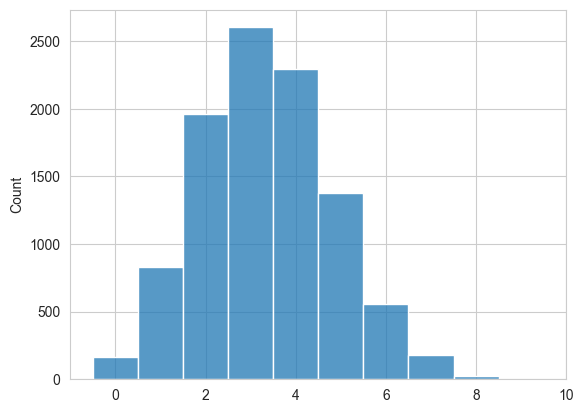

In [28]:
numbers = generate_binomial(10, 1/3, 10000, seed=2137)
sns.histplot(numbers, discrete=True)

## Mixed Distribution with Given CDF

The distribution with the given cumulative distribution function (CDF) $F(x)$ consists of three components:

$$
F(x) = \frac{1}{3} F_{B(10, 1/3)}(x) + \frac{1}{3} \Phi(x) + \frac{1}{3} F_{\text{EXP}(1)}(x)
$$

where:

- $F_{B(10, 1/3)}(x)$ is the CDF of the **binomial distribution** $B(10, 1/3)$.
- $\Phi(x)$ is the CDF of the **normal distribution** $N(0,1)$.
- $F_{\text{EXP}(1)}(x)$ is the CDF of the **exponential distribution** $\text{Exp}(1)$.

### **Generating Random Numbers from This Distribution**
To generate random numbers from this distribution, we use the **mixture model method**:

1. **Select the component**:  
   - Draw a random number $U \sim U(0,1)$.
   - If $U < \frac{1}{3}$, choose the **binomial distribution** $B(10,1/3)$.
   - If $\frac{1}{3} \leq U < \frac{2}{3}$, choose the **normal distribution** $N(0,1)$.
   - Otherwise, choose the **exponential distribution** $\text{Exp}(1)$.

2. **Generate a random number** from the chosen distribution.

This method ensures that each component contributes equally (with probability $\frac{1}{3}$) to the final distribution


In [29]:
def generate_mixed(n, seed=2137):
    u = lcg(n+1, seed=seed)
    u = u[1:]
    normal_num = normal_box_muller(n, seed_one=seed**2, seed_two=seed*2+1)
    exp_num = exponential_generator(1, n, seed=seed*3+seed**4)
    binomial_num = generate_binomial(10, 1/3, n, seed=seed*5)
    numbers = []
    for i in range(n):
        if u[i] < 1/3:
            numbers.append(binomial_num[i])
        elif u[i] < 2/3:
            numbers.append(normal_num[i])
        else:
            numbers.append(exp_num[i])
    return np.array(numbers)

<Axes: ylabel='Count'>

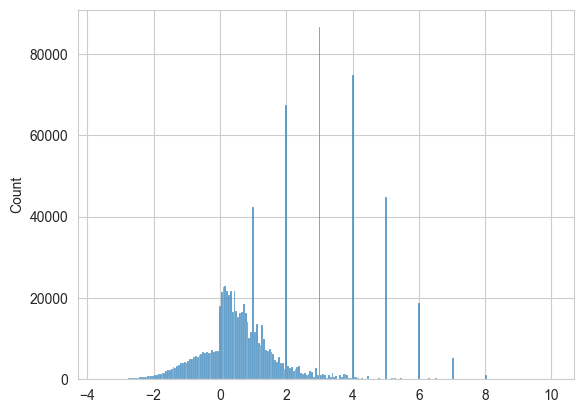

In [30]:
numbers = generate_mixed(1000_000, seed=2137)
sns.histplot(numbers)

<Axes: ylabel='Proportion'>

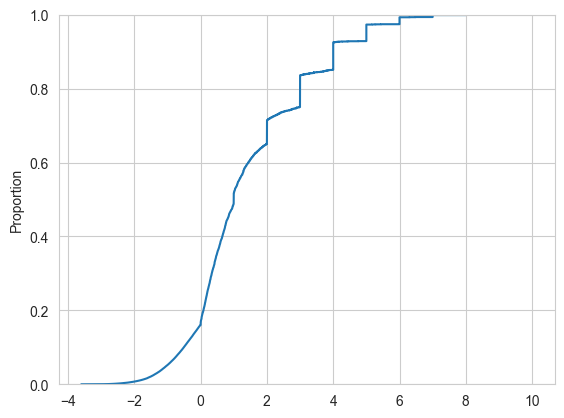

In [31]:
sns.ecdfplot(numbers)

<Axes: >

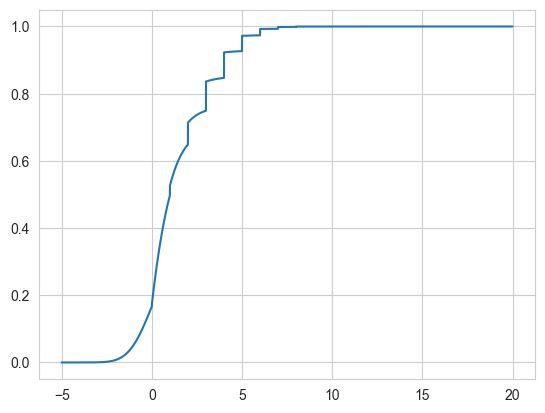

In [32]:
#compare with F
import scipy.stats as stats
x = np.linspace(-5, 20, 100_000)
y = 1/3 * stats.binom.cdf(x, 10, 1/3) + 1/3 * stats.norm.cdf(x) + 1/3 * stats.expon.cdf(x,scale=1)
sns.lineplot(x=x, y=y)

<Axes: ylabel='Proportion'>

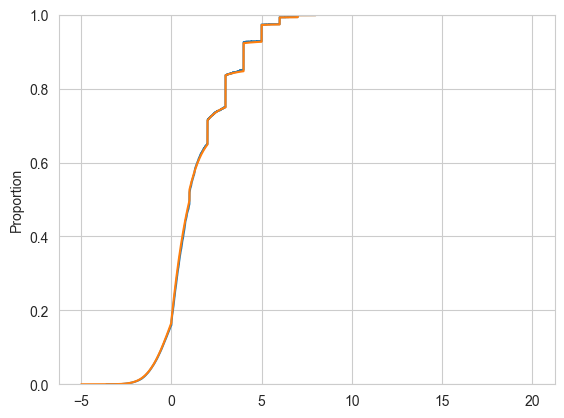

In [33]:
#on the same plot
sns.ecdfplot(numbers)
sns.lineplot(x=x, y=y)

### E
in terminal:
python setup.py build_ext --inplace

In [1108]:
import jkiss

# Generate 10 random numbers
for _ in range(10):
    print(jkiss.random())


0.13044139207340777
0.6059686637017876
0.5919378669932485
0.7736152252182364
0.536980030592531
0.8086268142797053
0.9553655311465263
0.16728980233892798
0.388844583183527
0.850704365875572


<Axes: ylabel='Count'>

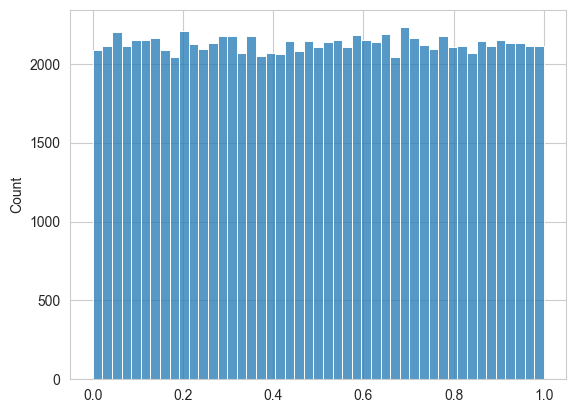

In [1109]:
lots_of_numbers = [jkiss.random() for _ in range(100000)]
sns.histplot(lots_of_numbers)

In [1110]:
kstest(lots_of_numbers, 'uniform')

KstestResult(statistic=0.0018543714817613743, pvalue=0.8811015407132398, statistic_location=0.5153043714817613, statistic_sign=-1)

<Axes: ylabel='Proportion'>

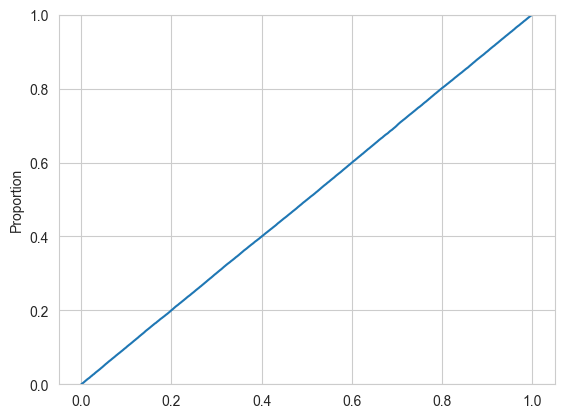

In [1111]:
sns.ecdfplot(lots_of_numbers)

### Comparing with the built-in function

In [1113]:
import timeit
print(timeit.timeit('np.random.rand(100000)', setup='import numpy as np', number=1000))
print(timeit.timeit('[jkiss.random() for _ in range(100000)]', setup='import jkiss', number=1000))

0.29474429102265276
3.3028583749837708


### Conclusion
built-in 10 times faster

### F

In [1122]:
n=100_000_000
kiss_numbers = [jkiss.random() for _ in range(n)]
lcg_numbers = lcg(n)
# binary 32-bit float representation
kiss_numbers = np.array(kiss_numbers, dtype=np.float32)
lcg_numbers = np.array(lcg_numbers, dtype=np.float32)
#write to binary file
with open('jkiss_num.bin', 'wb') as f:
    f.write(kiss_numbers.tobytes())
with open('lcg_num.bin', 'wb') as f:
    f.write(lcg_numbers.tobytes())

here is problem, we need to send a lot of numbers to get good results for dieharder tests

In [1123]:
with open('jkiss_output.txt','r') as file:
    print(file.read())

#=============================================================================#
#            dieharder version 3.31.1 Copyright 2003 Robert G. Brown          #
#=============================================================================#
   rng_name    |           filename             |rands/second|
 file_input_raw|                   jkiss_num.bin|  4.94e+07  |
#=============================================================================#
        test_name   |ntup| tsamples |psamples|  p-value |Assessment
#=============================================================================#
   diehard_birthdays|   0|       100|     100|0.00000000|  FAILED  
      diehard_operm5|   0|   1000000|     100|0.98235257|  PASSED  
  diehard_rank_32x32|   0|     40000|     100|0.00000000|  FAILED  
    diehard_rank_6x8|   0|    100000|     100|0.80480244|  PASSED  
   diehard_bitstream|   0|   2097152|     100|0.00000000|  FAILED  
        diehard_opso|   0|   2097152|     100|0.33779680|  PASSED 

In [1124]:
with open('lcg_output.txt','r') as file:
    print(file.read())

#=============================================================================#
#            dieharder version 3.31.1 Copyright 2003 Robert G. Brown          #
#=============================================================================#
   rng_name    |           filename             |rands/second|
 file_input_raw|                     lcg_num.bin|  6.13e+07  |
#=============================================================================#
        test_name   |ntup| tsamples |psamples|  p-value |Assessment
#=============================================================================#
   diehard_birthdays|   0|       100|     100|0.00000000|  FAILED  
      diehard_operm5|   0|   1000000|     100|0.00000000|  FAILED  
  diehard_rank_32x32|   0|     40000|     100|0.00000000|  FAILED  
    diehard_rank_6x8|   0|    100000|     100|0.00000000|  FAILED  
   diehard_bitstream|   0|   2097152|     100|0.00000000|  FAILED  
        diehard_opso|   0|   2097152|     100|0.00000000|  FAILED 